<a href="https://colab.research.google.com/github/wilmi94/MasterThesis/blob/main/Access_SDO_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Access SDO Data from Python

To access the JSOC DRMS from Python, we first need to import the drms module and create an instance of the Client class:

In [ ]:
pip install drms

In [ ]:
import numpy as np
import pandas as pd
import drms
import matplotlib.pyplot as plt
from astropy.io import fits
import drms

Create DRMS client, uses the JSOC baseurl by default, set debug=True to see the DRMS query URLs

In [ ]:
client = drms.Client()

All available data series can be now retrieved by calling the `drms.client.Client.series()` method. HMI series names start with `"hmi."`, AIA series names with `"aia."` and the names of MDI series with `"mdi."`.

The first (optional) parameter of this method takes a regular expression that allows you to filter the result. If you, for example, want to obtain a list of HMI series, with a name that start with the string `"m_"`, you can write:

In [ ]:
client.series(r'hmi\.m'); # show available data

## Downloading and plotting a HMI synoptic data

download HMI synoptic data from JSOC and make a plot.

Construct the DRMS query string: “Series[Carrington rotation]”

In [ ]:
#qstr = 'hmi.synoptic_mr_720s[2251]'
qstr = 'hmi.mrdailysynframe_720s_nrt[$]'

# Send request to the DRMS server
print('Querying keyword data...\n -> {qstr}')
segname = 'data' #'synopMr'
results, filenames = client.query(qstr, key=drms.const.all, seg=segname)
print(f' -> {len(results)} lines retrieved.')

# Use only the first line of the query result
results = results.iloc[0]
print('Retrived Data: \n', results)

fname = f'http://jsoc.stanford.edu{filenames[segname][0]}'

# Read the data segment
# Note: HTTP downloads get cached in ~/.astropy/cache/downloads
print(f'Reading data from {fname}...')
a = fits.getdata(fname)
ny, nx = a.shape

Querying keyword data...
 -> {qstr}
 -> 1 lines retrieved.
Retrived Data: 
 DATE                                 2022-01-26T14:05:17Z
TELESCOP                                          SDO/HMI
INSTRUME                                     HMI_COMBINED
WAVELNTH                                             6173
BUNIT                                             Mx/cm^2
                                ...                      
DATARMS                                           32.1081
DATASKEW                                         -3.24408
DATAKURT                                          736.322
CALVER64                                        268706066
CODEVER     :127:JSOC Production:/home/jsocprod:/bin/tcsh
Name: 0, Length: 86, dtype: object
Reading data from http://jsoc.stanford.edu/SUM16/D1482178487/S00000/data.fits...


## Plot the image

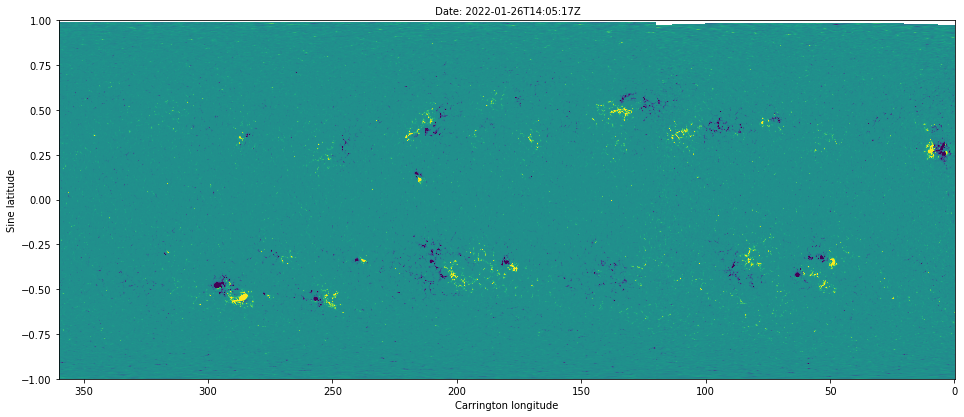

In [ ]:
# Convert pixel to world coordinates using WCS keywords
xmin = (1 - results.CRPIX1) * results.CDELT1 + results.CRVAL1
xmax = (nx - results.CRPIX1) * results.CDELT1 + results.CRVAL1
ymin = (1 - results.CRPIX2) * results.CDELT2 + results.CRVAL2
ymax = (ny - results.CRPIX2) * results.CDELT2 + results.CRVAL2

# Convert to Carrington longitude
xmin = results.LON_LAST - xmin
xmax = results.LON_LAST - xmax

# Compute the plot extent used with imshow
extent = (
    xmin - abs(results.CDELT1) / 2,
    xmax + abs(results.CDELT1) / 2,
    ymin - abs(results.CDELT2) / 2,
    ymax + abs(results.CDELT2) / 2,
)

# Aspect ratio for imshow in respect to the extent computed above
aspect = abs((xmax - xmin) / nx * ny / (ymax - ymin))

# Create plot
fig, ax = plt.subplots(1, 1, figsize=(13.5, 6))
#ax.set_title(f'{qstr}, Time: {results.T_START} ... {results.T_STOP}', fontsize='medium')
ax.set_title(f' Date: {results.DATE}', fontsize='medium')
ax.imshow(
    a, vmin=-300, vmax=300, origin='lower', interpolation='nearest', extent=extent, aspect=aspect)#, cmap='gray') # for grayscale include , cmap='gray'

ax.invert_xaxis()
ax.set_xlabel('Carrington longitude')
ax.set_ylabel('Sine latitude')
fig.tight_layout()

plt.show()

## Next Steps:
- try to automatize the download and figure retrieval
- look how and when CME's happened
- label data...is there a data bank already availbale?
- define performance metrics
- try to do first CNN tests 